In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt
!pip install dtreeviz

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = pd.read_csv('/Users/justinchen/Documents/mental_health_subreddits_dataset.csv')

In [4]:
sample = dataset.sample(20000)
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16386,8653494,depression,1611093447,"I would love to , but he's states away from me...",0.3818
19468,9781475,depression,1608101825,Not everybody became depressed because of COVI...,0.3404
11097,6365641,covid19_support,1618252396,Even young and healthy people can get COVID-19...,-0.3400
20665,10225301,depression,1606948862,I'm sorry that your going through all this. An...,-0.0165
7207,4377874,mentalhealth,1624908618,Go for a long walk. Or a run. Or maybe a cycle...,0.0000


In [5]:
count = Counter()
for index, row in sample.iterrows():
    if row['subreddit.name'] == 'anxiety':
        count['anxiety'] += 1
    if row['subreddit.name'] == 'depression':
        count['depression'] += 1
    if row['subreddit.name'] == 'suicidewatch':
        count['SuicideWatch'] += 1
    if row['subreddit.name'] == 'mentalhealth':
        count['mentalhealth'] += 1
    if row['subreddit.name'] == 'covid19_support':
        count['COVID19_support'] += 1
count

Counter({'depression': 2576,
         'COVID19_support': 7008,
         'mentalhealth': 1408,
         'anxiety': 7278,
         'SuicideWatch': 1730})

## Preprocessing

In [6]:
import re #regex library used for substituting words

In [7]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [9]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [10]:
sample.body = sample.body.apply(lambda x: preprocessing(x))

In [11]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
10804,6228784,suicidewatch,1618647145,way get dirt broke know anyone state due covid...,0.7496
21007,10365549,suicidewatch,1606581431,done research done hard enough without covid c...,0.5487
5788,3582971,covid19_support,1627404911,talking early onset dementia read example,0.0000
12504,6999970,anxiety,1616251936,anxious covid think going needle feels manageable,-0.3167
9614,5626949,depression,1620383148,trying better since came army years ago hence ...,0.7774


In [11]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
    else:
        sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

Text(0.5, 1.0, 'Sentiment Data Distribution')

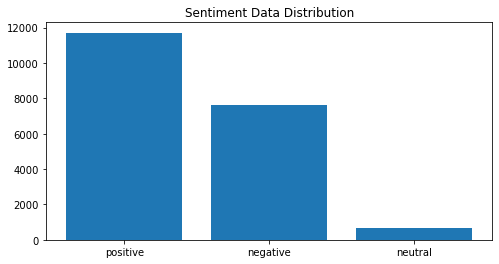

In [12]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [13]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
43069,16933287,covid19_support,1586118631,little brother sick christmas week covid sympt...,negative
34885,14698214,depression,1593887677,yeah really bad covid social distancing enable...,negative
24591,11652122,suicidewatch,1603057097,dude death answer tried kill work understood w...,positive
24051,11480801,covid19_support,1603590027,hey thanks replies input greatly appreciated y...,positive
40029,16087761,anxiety,1588880060,big emily oster fan economist specializes pare...,positive


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16000
Test Data size 4000


## Vectorizing

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
vectorizer = TfidfVectorizer(max_features=10000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [17]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (16000, 8907)
x_test Shape: (4000, 8907)


In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (16000, 1)
y_test shape: (4000, 1)


## Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
model = RandomForestClassifier()
model.fit(x_train, y_train.ravel())
predicted_labels = model.predict(x_test)
print ('Accuracy:', model.score(x_test, y_test))

Accuracy: 0.7485


## Feature Importances

In [22]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [28]:
from sklearn.tree import export_text
for tree in model.estimators_:
    text_representation = export_text(tree, feature_names = vectorizer.get_feature_names())
    print(text_representation)

|--- cant <= 0.15
|   |--- thread <= 0.19
|   |   |--- like <= 0.04
|   |   |   |--- support <= 0.12
|   |   |   |   |--- fucked <= 0.08
|   |   |   |   |   |--- leg <= 0.06
|   |   |   |   |   |   |--- problems <= 0.13
|   |   |   |   |   |   |   |--- positive <= 0.06
|   |   |   |   |   |   |   |   |--- bad <= 0.10
|   |   |   |   |   |   |   |   |   |--- blown <= 0.10
|   |   |   |   |   |   |   |   |   |   |--- friend <= 0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 363
|   |   |   |   |   |   |   |   |   |   |--- friend >  0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 50
|   |   |   |   |   |   |   |   |   |--- blown >  0.10
|   |   |   |   |   |   |   |   |   |   |--- year <= 0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- year >  0.02
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- bad 

|--- fuck <= 0.06
|   |--- sucks <= 0.10
|   |   |--- contact <= 0.14
|   |   |   |--- best <= 0.01
|   |   |   |   |--- painful <= 0.17
|   |   |   |   |   |--- enjoy <= 0.06
|   |   |   |   |   |   |--- panic <= 0.08
|   |   |   |   |   |   |   |--- worse <= 0.09
|   |   |   |   |   |   |   |   |--- try <= 0.05
|   |   |   |   |   |   |   |   |   |--- hopelessness <= 0.06
|   |   |   |   |   |   |   |   |   |   |--- relief <= 0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 384
|   |   |   |   |   |   |   |   |   |   |--- relief >  0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 19
|   |   |   |   |   |   |   |   |   |--- hopelessness >  0.06
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- try >  0.05
|   |   |   |   |   |   |   |   |   |--- time <= 0.09
|   |   |   |   |   |   |   |   |   |   |--- im <= 0.21
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of 

|--- post <= 0.17
|   |--- negative <= 0.13
|   |   |--- dead <= 0.11
|   |   |   |--- much <= 0.03
|   |   |   |   |--- love <= 0.04
|   |   |   |   |   |--- luck <= 0.07
|   |   |   |   |   |   |--- died <= 0.02
|   |   |   |   |   |   |   |--- better <= 0.04
|   |   |   |   |   |   |   |   |--- scared <= 0.07
|   |   |   |   |   |   |   |   |   |--- life <= 0.02
|   |   |   |   |   |   |   |   |   |   |--- stuck <= 0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 340
|   |   |   |   |   |   |   |   |   |   |--- stuck >  0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |   |   |   |   |   |--- life >  0.02
|   |   |   |   |   |   |   |   |   |   |--- hell <= 0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 73
|   |   |   |   |   |   |   |   |   |   |--- hell >  0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |  

|--- bot <= 0.03
|   |--- long <= 0.25
|   |   |--- panicking <= 0.20
|   |   |   |--- angry <= 0.02
|   |   |   |   |--- disorder <= 0.08
|   |   |   |   |   |--- dose <= 0.02
|   |   |   |   |   |   |--- best <= 0.06
|   |   |   |   |   |   |   |--- appreciate <= 0.15
|   |   |   |   |   |   |   |   |--- beautiful <= 0.03
|   |   |   |   |   |   |   |   |   |--- damage <= 0.09
|   |   |   |   |   |   |   |   |   |   |--- helps <= 0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 394
|   |   |   |   |   |   |   |   |   |   |--- helps >  0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 57
|   |   |   |   |   |   |   |   |   |--- damage >  0.09
|   |   |   |   |   |   |   |   |   |   |--- pressure <= 0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |   |--- pressure >  0.11
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |


|--- concerns <= 0.16
|   |--- relief <= 0.09
|   |   |--- message <= 0.05
|   |   |   |--- hope <= 0.01
|   |   |   |   |--- like <= 0.03
|   |   |   |   |   |--- help <= 0.03
|   |   |   |   |   |   |--- astrazeneca <= 0.13
|   |   |   |   |   |   |   |--- immune <= 0.17
|   |   |   |   |   |   |   |   |--- therapist <= 0.13
|   |   |   |   |   |   |   |   |   |--- pandemic <= 0.16
|   |   |   |   |   |   |   |   |   |   |--- died <= 0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 365
|   |   |   |   |   |   |   |   |   |   |--- died >  0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 30
|   |   |   |   |   |   |   |   |   |--- pandemic >  0.16
|   |   |   |   |   |   |   |   |   |   |--- fault <= 0.14
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 27
|   |   |   |   |   |   |   |   |   |   |--- fault >  0.14
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |

|--- die <= 0.06
|   |--- subreddit <= 0.17
|   |   |--- lying <= 0.08
|   |   |   |--- easier <= 0.02
|   |   |   |   |--- problems <= 0.13
|   |   |   |   |   |--- kill <= 0.10
|   |   |   |   |   |   |--- thank <= 0.12
|   |   |   |   |   |   |   |--- stomach <= 0.07
|   |   |   |   |   |   |   |   |--- flu <= 0.07
|   |   |   |   |   |   |   |   |   |--- issues <= 0.19
|   |   |   |   |   |   |   |   |   |   |--- good <= 0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 359
|   |   |   |   |   |   |   |   |   |   |--- good >  0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 124
|   |   |   |   |   |   |   |   |   |--- issues >  0.19
|   |   |   |   |   |   |   |   |   |   |--- side <= 0.14
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |   |--- side >  0.14
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- flu

|--- thank <= 0.12
|   |--- hell <= 0.08
|   |   |--- numb <= 0.13
|   |   |   |--- started <= 0.07
|   |   |   |   |--- still <= 0.05
|   |   |   |   |   |--- stop <= 0.08
|   |   |   |   |   |   |--- resort <= 0.10
|   |   |   |   |   |   |   |--- fucked <= 0.07
|   |   |   |   |   |   |   |   |--- risk <= 0.14
|   |   |   |   |   |   |   |   |   |--- infected <= 0.08
|   |   |   |   |   |   |   |   |   |   |--- constant <= 0.14
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 352
|   |   |   |   |   |   |   |   |   |   |--- constant >  0.14
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 17
|   |   |   |   |   |   |   |   |   |--- infected >  0.08
|   |   |   |   |   |   |   |   |   |   |--- might <= 0.07
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 56
|   |   |   |   |   |   |   |   |   |   |--- might >  0.07
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |  

In [33]:
fig = plt.figure(figsize=(25,20))
for tree in model.estimators_:
    tree.plot_tree(tree, 
                  feature_names=vectorizer.get_feature_names(),  
                  class_names=['negative', 'neutral', 'positive'],
                   filled=True)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'plot_tree'

<Figure size 1800x1440 with 0 Axes>

In [39]:
from dtreeviz.trees import dtreeviz # remember to load the package

for tree in model.estimators_:
    viz = dtreeviz(tree, x_train, y_train,
                   target_name="target",
                   feature_names=vectorizer.get_feature_names(),
                   class_names=['negative', 'neutral', 'positive'])

viz

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [ ]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(tree, out_file=None, 
                                feature_names=vectorizer.get_feature_names(),  
                                class_names=iris.target_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

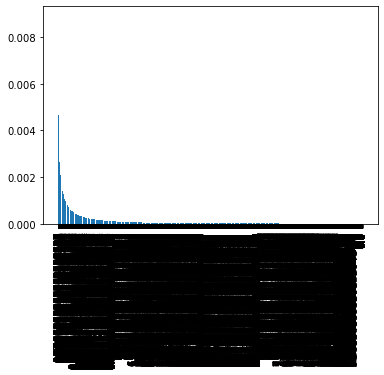

In [72]:
# Get feature importances from our random forest model
importances = model.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(importances)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()